In [8]:
import os
import sys
from typing import Tuple, List

sys.path.append(os.path.join(os.getcwd(), "LightGlue"))
sys.path.append(os.path.join(os.getcwd(), "SuperGluePretrainedNetwork"))
sys.path.append(os.path.join(os.getcwd(), "omniglue"))
sys.path.append(os.path.join(os.getcwd(), "wildlife-tools"))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import timm
import torchvision.transforms as T
from argparse import ArgumentParser
from tqdm import tqdm
from PIL import Image

from wildlife_datasets import analysis, datasets, loader, splits
from wildlife_tools.features import DeepFeatures
from wildlife_tools.data import WildlifeDataset 
from wildlife_tools.similarity import CosineSimilarity

from LightGlue.lightglue import LightGlue, SuperPoint, SIFT
from LightGlue.lightglue.utils import load_image, rbd
from LightGlue.lightglue import viz2d

from SuperGluePretrainedNetwork import match_pairs as SuperGlueMatching

# from omniglue import omniglue_extract as omniglue

import cv2


In [4]:
def get_dataset(dataset_name: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, str]:
    """
    Load dataset and split into training, validation, and test sets.

    Args:
        dataset_name (str): Name of the dataset.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, str]: DataFrames for training, validation, and test sets, and the dataset root directory.
    """
    if dataset_name == "LeopardID2022":
        d = datasets.LeopardID2022("datasets/LeopardID2022")
    elif dataset_name == "HyenaID2022":
        d = datasets.HyenaID2022("datasets/HyenaID2022")
    elif dataset_name == "ATRW":
        d = datasets.ATRW("datasets/ATRW")
    elif dataset_name == "WII":
        import wii_dataset
        d = wii_dataset.WII("datasets/WII")
    else:
        raise ValueError("Invalid dataset name")
    
    # remove those samples where an identity has fewer than 5 samples
    d.df = d.df.groupby("identity").filter(lambda x: len(x) >= 5)

    if dataset_name == "ATRW":
        df_train = d.df[d.df["original_split"] == "train"]
        df_test = d.df[d.df["original_split"] == "test"]
        df_val = df_test

    elif dataset_name == "WII":
        df_train = d.df[d.df["split"] == "train"]
        df_test = d.df[d.df["split"] == "test"]

        # remove those entries that dont have a flank column
        df_test = df_test.dropna(subset=["flank"])
        df_test = df_test.dropna(subset=["gallery_split"])

        df_val = df_test

    else:
        n_identites = len(d.df['identity'].unique())

        n_test_ids = int(np.ceil(0.33 * n_identites))
        n_val_ids = int(np.ceil(0.2 * (n_identites - n_test_ids)))

        splitter = splits.DisjointSetSplit(n_class_test=n_test_ids) # 64 test IDs = ceil(0.33 * 193)
        # splitter = splits.ClosedSetSplit(0.67)
        for idx_train, idx_test in splitter.split(d.df):
            _df_train, df_test = d.df.loc[idx_train], d.df.loc[idx_test]

        splitter_2 = splits.DisjointSetSplit(n_class_test=n_val_ids) # 26 val IDs = ceil(0.2 * 129)
        for idx_train, idx_val in splitter_2.split(_df_train):
            df_train, df_val = _df_train.loc[idx_train], _df_train.loc[idx_val]


    df_train = df_train.groupby("identity").filter(lambda x: len(x) >= 5)
    df_test = df_test.groupby("identity").filter(lambda x: len(x) >= 5)
    df_val = df_val.groupby("identity").filter(lambda x: len(x) >= 5)

    return df_train, df_val, df_test, d.root

In [9]:
def get_query_gallery_split(df: pd.DataFrame, root: str, transform: T.Compose, dataset_name: str) -> Tuple[WildlifeDataset, WildlifeDataset]:
    """
    Split dataset into query and gallery sets. For each identity, the first sample is used as the gallery image and the rest are used as query images.

    Args:
        df (pd.DataFrame): DataFrame containing dataset information.
        root (str): Root directory of the dataset.
        transform (T.Compose): Transformations to apply to the images.
        dataset_name (str): Name of the dataset.

    Returns:
        Tuple[WildlifeDataset, WildlifeDataset]: Query and gallery datasets.
    """

    if dataset_name == "WII":
        df_left = df[df["flank"] == "left"]
        df_right = df[df["flank"] == "right"]

        df_left_query = df_left[df_left["gallery_split"] == "query"]
        df_left_gallery = df_left[df_left["gallery_split"] == "gallery"]

        df_right_query = df_right[df_right["gallery_split"] == "query"]
        df_right_gallery = df_right[df_right["gallery_split"] == "gallery"]

        dataset_left_query = WildlifeDataset(df_left_query, root, transform=transform, img_load="bbox")
        dataset_left_gallery = WildlifeDataset(df_left_gallery, root, transform=transform, img_load="bbox")

        dataset_right_query = WildlifeDataset(df_right_query, root, transform=transform, img_load="bbox")
        dataset_right_gallery = WildlifeDataset(df_right_gallery, root, transform=transform, img_load="bbox")

        return dataset_left_query, dataset_left_gallery, dataset_right_query, dataset_right_gallery
    else:
        df_query = df.groupby("identity").apply(lambda x: x.iloc[1:])
        df_gallery = df.groupby("identity").apply(lambda x: x.iloc[:1])

    if dataset_name == "ATRW":
        dataset_query = WildlifeDataset(df_query, root, transform=transform)
        dataset_gallery = WildlifeDataset(df_gallery, root, transform=transform)
    else:    
        dataset_query = WildlifeDataset(df_query, root, transform=transform, img_load="bbox")
        dataset_gallery = WildlifeDataset(df_gallery, root, transform=transform, img_load="bbox")
    return dataset_query, dataset_gallery


In [10]:
def compute_metrics(preds: np.ndarray, gt: np.ndarray) -> None:
    """
    Compute top-1, top-3, and top-5 accuracy, precision, and recall.
    
    Args:
        preds (np.ndarray): (N, 5) Predictions.
        gt (np.ndarray): (N,) Ground truth.
    """

    # compute top-k accuracy
    top_1 = np.sum(preds[:, 0] == gt) / len(gt)
    top_3 = np.sum([gt[i] in preds[i, :3] for i in range(len(gt))]) / len(gt)
    top_5 = np.sum([gt[i] in preds[i, :] for i in range(len(gt))]) / len(gt)

    # compute precision and recall for k=1, 3, 5
    TP = np.sum( preds[:, 0] == gt )
    FP = np.sum( preds[:, 0] != gt )
    FN = len(gt) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    print("------k=1------")
    print(f"Top-1 Accuracy: {100*top_1:.2f}%")
    # print(f"Precision: {100*precision:.2f}%")
    # print(f"Recall: {100*recall:.2f}%")
    # print(F"TP: {TP}, FP: {FP}, FN: {FN}")
    print(f"Correct Matches: {TP}, Incorrect Matches: {FP}")

    # k = 3
    TP = np.sum([gt[i] in preds[i, :3] for i in range(len(gt))])
    FP = np.sum([gt[i] not in preds[i, :3] for i in range(len(gt))])
    FN = len(gt) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    print("------k=3------")
    print(f"Top-3 Accuracy: {100*top_3:.2f}%")
    # print(f"Precision: {100*precision:.2f}%")
    # print(f"Recall: {100*recall:.2f}%")
    # print(F"TP: {TP}, FP: {FP}, FN: {FN}")
    print(f"Correct Matches: {TP}, Incorrect Matches: {FP}")

    # k = 5
    TP = np.sum([gt[i] in preds[i, :] for i in range(len(gt))])
    FP = np.sum([gt[i] not in preds[i, :] for i in range(len(gt))])
    FN = len(gt) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    print("------k=5------")
    print(f"Top-5 Accuracy: {100*top_5:.2f}%")
    # print(f"Precision: {100*precision:.2f}%")
    # print(f"Recall: {100*recall:.2f}%")
    # print(f"TP: {TP}, FP: {FP}, FN: {FN}")
    print(f"Correct Matches: {TP}, Incorrect Matches: {FP}")

In [45]:
DATASET = "WII"
detector = "superpoint"
matcher =  "lightglue"

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df_train, df_val, df_test, root = get_dataset(DATASET)

if matcher == "arcface" or detector == "arcface":
    transforms = T.Compose([
        T.Resize([112, 112], antialias=True),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
else:
    transforms = T.Compose([
        T.Resize([384, 384]),
        T.ToTensor(),
        T.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
    ])

if detector == "superpoint":
    extractor = SuperPoint(max_num_keypoints=2048).eval().cuda()  # load the extractor
if matcher == "lightglue":
    MATCHER = LightGlue(features=detector).eval().cuda()  # load the matcher

In [19]:
print(f"Number of training samples: {len(df_train)}")
print(f"Number of validation samples: {len(df_val)}")
print(f"Number of test samples: {len(df_test)}")
left_query, left_gallery, right_query, right_gallery = get_query_gallery_split(df_val, root, transforms, dataset_name=DATASET)
print(f"Number of left query samples: {len(left_query)}")
print(f"Number of left gallery samples: {len(left_gallery)}")
print(f"Number of right query samples: {len(right_query)}")
print(f"Number of right gallery samples: {len(right_gallery)}")


Number of training samples: 3405
Number of validation samples: 3498
Number of test samples: 3498
Number of left query samples: 1233
Number of left gallery samples: 465
Number of right query samples: 1334
Number of right gallery samples: 466


In [8]:
# sys.path.append(os.path.join(os.getcwd(), "insightface/recognition/arcface_torch/"))
# from backbones import get_model

# weights_path = "/home/atharv21027/ReID-with-graphs/insightface/recognition/arcface_torch/work_dirs/ms1mv3_r50_onegpu/model.pt"
# arcface = get_model("r50", fp16=False)
# arcface.load_state_dict(torch.load(weights_path))
# arcface = arcface.eval().to(device)

In [11]:
preds_path = f"outputs/{matcher}/{DATASET}/{detector}_preds.npy"
if os.path.exists(preds_path):
    PREDS = np.load(preds_path)
    GT = np.load(f"outputs/{matcher}/{DATASET}/{detector}_gt.npy")
    compute_metrics(PREDS, GT)

------k=1------
Top-1 Accuracy: 3.31%
Precision: 3.31%
Recall: 3.31%
TP: 122, FP: 3567, FN: 3567
------k=3------
Top-3 Accuracy: 7.37%
Precision: 7.37%
Recall: 7.37%
TP: 272, FP: 3417, FN: 3417
------k=5------
Top-5 Accuracy: 10.84%
Precision: 10.84%
Recall: 10.84%
TP: 400, FP: 3289, FN: 3289


In [20]:
left_memo_gallery = []
left_memo_query = []
right_memo_gallery = []
right_memo_query = []

gallery_labels_left = []
gallery_labels_right = []

In [35]:
gallery_labels_left = []
gallery_labels_right = []
for i in tqdm(range(len(left_gallery)), desc="Memoizing left gallery"):
    gallery_labels_left.append(left_gallery[i][1])
for i in tqdm(range(len(right_gallery)), desc="Memoizing right gallery"):
    gallery_labels_right.append(right_gallery[i][1])

    

Memoizing right gallery: 100%|██████████| 466/466 [00:39<00:00, 11.72it/s]


In [31]:
# if matcher == "megadescriptor":
#     top_5_matches = get_matches_megadesc(dataset_query, dataset_gallery, device)
#     predictions = np.array(top_5_matches)
#     gt = np.array([dataset_query[i][1] for i in range(len(dataset_query))])
#     return predictions, gt

if matcher == "omniglue":
        og = omniglue.OmniGlue(
        og_export='omniglue/models/og_export',
        sp_export='omniglue/models/sp_v6',
        dino_export='omniglue/models/dinov2_vitb14_pretrain.pth',
    )

if matcher == "lightglue" or matcher == "superglue":
    if detector == "superpoint":
        extractor = SuperPoint(max_num_keypoints=2048).eval().cuda()  # load the extractor
    elif detector == "sift":
        extractor = SIFT(max_num_keypoints=2048).eval().cuda()
    else:
        raise ValueError(f"Invalid keypoint detector: {detector}")


    MATCHER = LightGlue(features=detector).eval().cuda()
    for i in tqdm(range(len(left_gallery)), desc="Memoizing left gallery"):
        left_memo_gallery.append(extractor.extract(left_gallery[i][0].unsqueeze(0).to(device)))
        gallery_labels_left.append(left_gallery[i][1])

    for i in tqdm(range(len(left_query)), desc="Memoizing left query"):
        left_memo_query.append(extractor.extract(left_query[i][0].unsqueeze(0).to(device)))

    for i in tqdm(range(len(right_gallery)), desc="Memoizing right gallery"):
        right_memo_gallery.append(extractor.extract(right_gallery[i][0].unsqueeze(0).to(device)))
        gallery_labels_right.append(right_gallery[i][1])

    for i in tqdm(range(len(right_query)), desc="Memoizing right query"):
        right_memo_query.append(extractor.extract(right_query[i][0].unsqueeze(0).to(device)))
            
if detector == "arcface" or matcher == "arcface":
    sys.path.append(os.path.join(os.getcwd(), "insightface/recognition/arcface_torch/"))
    from backbones import get_model

    weights_path = "/home/atharv21027/ReID-with-graphs/insightface/recognition/arcface_torch/work_dirs/ms1mv3_r50_onegpu/model.pt"
    arcface = get_model("r50", fp16=False)
    arcface.load_state_dict(torch.load(weights_path))
    arcface = arcface.eval().to(device)

    for i in tqdm(range(len(dataset_gallery)), desc="Memoizing gallery"):
        memo_gallery.append(arcface(dataset_gallery[i][0].unsqueeze(0).to(device)))
    for i in tqdm(range(len(dataset_query)), desc="Memoizing query"):
        memo_query.append(arcface(dataset_query[i][0].unsqueeze(0).to(device)))

Memoizing right query: 100%|██████████| 1334/1334 [03:30<00:00,  6.33it/s]


In [14]:
# write a function to display the k-th left flank image and the k-th right flank image
def display_flank_images(k: int, flank: str):
    # get the k-th left flank
    # img, label, flank = dataset_gallery[k]
    i = -1
    for j in range(len(dataset_gallery)):
        if dataset_gallery[j][2] == flank:
            if i == k:
                img, label, flank = dataset_gallery[j]
                break
            i += 1

    img = img.permute(1, 2, 0).numpy()

    img = (img + 1) / 2

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Flank: {flank}")

    plt.show()

In [36]:
# gallery_features_left = torch.cat(gallery_features_left, dim=0)
gallery_labels_left = np.array(gallery_labels_left)

# gallery_features_right = torch.cat(gallery_features_right, dim=0)
gallery_labels_right = np.array(gallery_labels_right)

In [37]:
gallery_labels_left

array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  5,  6,  7,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
       11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13,
       14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17,
       17, 18, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22,
       23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26,
       26, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28,  1,  1,  1,  4,
        4,  4,  5,  6,  6,  6,  6,  6, 10, 29, 29, 29, 14, 14, 14, 14, 16,
       16, 18, 18, 18, 18, 18, 19, 19, 19, 19, 22, 22, 22, 23, 23, 26, 28,
       28,  9, 29, 29, 29, 20, 20, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31,
       31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 34, 34, 34,
       34, 34, 34, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 37, 37,
       37, 37, 37, 37, 38

In [14]:
PREDS[:10]

array([[  7., 106.,  96.,  16.,   9.],
       [106.,  48.,  29.,  18.,  41.],
       [  8.,  46.,  30.,  91.,  18.],
       [  5.,   6.,  38.,  40.,  69.],
       [ 18.,  80.,  94.,   6.,  89.],
       [106.,  18.,  41., 111.,  85.],
       [ 31.,  91.,  29.,  65.,  93.],
       [106.,  85.,  41.,  22.,  40.],
       [ 45.,  35.,  36.,  60.,  52.],
       [101.,  30.,   1., 102.,  33.]])

In [38]:
for i in range(10):
    flank = "left"
    img, label = left_query[i]
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        query_feature = extractor.extract(img)
    sims = []
    if flank == "left":
        for gallery_feature in left_memo_gallery:

            matches01 = MATCHER({'image0': query_feature, 'image1': gallery_feature})
            feats0, feats1, matches01 = [rbd(x) for x in [query_feature, gallery_feature, matches01]]  # remove batch dimension
            matches = matches01['matches']  # indices with shape (K,2)
            points0 = feats0['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
            points1 = feats1['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)

            indices = matches01['scores'] > 0.05
            points0, points1 = points0[indices], points1[indices]
            matches01['matches'] = matches01['matches'][indices]
                
            matches01['scores'] = matches01['scores'][indices]

            sims.append(len(matches01['matches']))
    else:
        for gallery_feature in right_memo_gallery:

            matches01 = MATCHER({'image0': query_feature, 'image1': gallery_feature})
            feats0, feats1, matches01 = [rbd(x) for x in [query_feature, gallery_feature, matches01]]  # remove batch dimension
            matches = matches01['matches']  # indices with shape (K,2)
            points0 = feats0['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
            points1 = feats1['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)

            indices = matches01['scores'] > 0.05
            points0, points1 = points0[indices], points1[indices]
            matches01['matches'] = matches01['matches'][indices]
                
            matches01['scores'] = matches01['scores'][indices]

            sims.append(len(matches01['matches']))
    sims = np.array(sims)
    if flank == "left":
        preds = gallery_labels_left[np.argsort(sims)[::-1]]
    else:
        preds = gallery_labels_right[np.argsort(sims)[::-1]]
    conf_scores = np.sort(sims)[::-1]

    print(f"Top 5 IDs: {preds[:5]}")
    print(f"cosine_sim: {conf_scores[:5]}")
    print(f"GT identity: {label}")
    if flank == "left":
        print(f"Similarity with GT: {sims[gallery_labels_left == label]}")
    else:
        print(f"Similarity with GT: {sims[gallery_labels_right == label]}")
    print(f"Rank of GT: {np.where(preds == label)[0][0] + 1}\n")

Top 5 IDs: [17  9 22 62 63]
cosine_sim: [70 64 62 61 56]
GT identity: 0
Similarity with GT: [ 2  9 43 19 17 10]
Rank of GT: 8

Top 5 IDs: [25 20 10 51 23]
cosine_sim: [185 180 154 151 150]
GT identity: 0
Similarity with GT: [  8 128  16  84   1   4]
Rank of GT: 21

Top 5 IDs: [ 0  0  0 20 51]
cosine_sim: [278 213 208 159 148]
GT identity: 0
Similarity with GT: [119 213 278 208   8  17]
Rank of GT: 1

Top 5 IDs: [ 0  0  7  0 31]
cosine_sim: [356 194 185 177 174]
GT identity: 0
Similarity with GT: [161 194 356 177   0   4]
Rank of GT: 1

Top 5 IDs: [ 0  0 50 56  8]
cosine_sim: [316 289 253 206 195]
GT identity: 0
Similarity with GT: [ 54 316 184 289   4  12]
Rank of GT: 1

Top 5 IDs: [25 51 19 38  0]
cosine_sim: [241 162 159 158 143]
GT identity: 0
Similarity with GT: [  7 135 112 143   3  19]
Rank of GT: 5

Top 5 IDs: [ 0  0  0 28 61]
cosine_sim: [126 108  81  62  57]
GT identity: 0
Similarity with GT: [  4 108  29  81 126  12]
Rank of GT: 1

Top 5 IDs: [ 0  0  0  0 21]
cosine_sim: [237

In [52]:
%matplotlib inline

In [47]:
def display_img(img: torch.Tensor) -> None:
    """
    Display an image tensor using PIL.

    Args:
        img (torch.Tensor): Image tensor.
    """
    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img + 1) / 2
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img)
    img.show()

def display_top_preds(i):
    flank = "left"
    if flank == "left":
        img, label = left_query[i]
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            query_feature = extractor.extract(img)
        sims = []
        for gallery_feature in left_memo_gallery:

            matches01 = MATCHER({'image0': query_feature, 'image1': gallery_feature})
            feats0, feats1, matches01 = [rbd(x) for x in [query_feature, gallery_feature, matches01]]  # remove batch dimension
            matches = matches01['matches']  # indices with shape (K,2)
            points0 = feats0['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
            points1 = feats1['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)

            indices = matches01['scores'] > 0.05
            points0, points1 = points0[indices], points1[indices]
            matches01['matches'] = matches01['matches'][indices]
                
            matches01['scores'] = matches01['scores'][indices]

            sims.append(len(matches01['matches']))
    else:
        img, label = right_query[i]
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            query_feature = extractor.extract(img)
        sims = []
        for gallery_feature in right_memo_gallery:

            matches01 = MATCHER({'image0': query_feature, 'image1': gallery_feature})
            feats0, feats1, matches01 = [rbd(x) for x in [query_feature, gallery_feature, matches01]]  # remove batch dimension
            matches = matches01['matches']  # indices with shape (K,2)
            points0 = feats0['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
            points1 = feats1['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)

            indices = matches01['scores'] > 0.05
            points0, points1 = points0[indices], points1[indices]
            matches01['matches'] = matches01['matches'][indices]
                
            matches01['scores'] = matches01['scores'][indices]

            sims.append(len(matches01['matches']))
    sims = np.array(sims)
    sort_indices = np.argsort(sims)[::-1]
    if flank == "left":
        preds = gallery_labels_left[sort_indices]
        gt_scores = sims[gallery_labels_left == label]
    else:
        preds = gallery_labels_right[sort_indices]
        gt_scores = sims[gallery_labels_right == label]
    conf_scores = sims[sort_indices]

    np.where(preds == label)[0][0] + 1

    # display three rows. First row has the image, second row has the images corresponding to top-5 predictions with similarity score as text caption, and the third row has the GT identity and similarity score
    img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img = (img + 1) / 2
    img = (img * 255).astype(np.uint8)

    fig1, ax1 = plt.subplots(1, 1, figsize=(3, 3))
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title("Query Image")

    if flank == "left":
        # Get all gallery images with the same identity as the GT
        gallery_flank_imgs = []
        gallery_GT_imgs = []
        for j in range(len(left_memo_gallery)):
            if left_gallery[j][2] == flank:
                gallery_flank_imgs.append(left_gallery[j][0])
                if (left_gallery[j][1] == label):
                    gallery_GT_imgs.append(left_gallery[j][0])
    else:
        gallery_flank_imgs = []
        gallery_GT_imgs = []
        for j in range(len(right_memo_gallery)):
            if right_gallery[j][2] == flank:
                gallery_flank_imgs.append(right_gallery[j][0])
                if (right_gallery[j][1] == label):
                    gallery_GT_imgs.append(right_gallery[j][0])

    gallery_flank_imgs = torch.stack(gallery_flank_imgs, dim=0)
    gallery_GT_imgs = torch.stack(gallery_GT_imgs, dim=0)

    gallery_flank_imgs = gallery_flank_imgs[sort_indices.copy()]

    # Second graph: Display top-5 predictions
    fig2, axs2 = plt.subplots(1, 5, figsize=(20, 5))
    for j in range(5):
        pred_img = gallery_flank_imgs[j].permute(1, 2, 0).cpu().numpy()
        pred_img = (pred_img + 1) / 2
        pred_img = (pred_img * 255).astype(np.uint8)
        axs2[j].imshow(pred_img)
        axs2[j].axis("off")
        axs2[j].set_title(f"ID: {preds[j]}\nMatches: {conf_scores[j]:.2f}")

    # Third graph: Display ground truth identity

    fig3, axs3 = plt.subplots(1, len(gallery_GT_imgs), figsize=(20, 5))
    for j in range(len(gallery_GT_imgs)):
        pred_img = gallery_GT_imgs[j].permute(1, 2, 0).cpu().numpy()
        pred_img = (pred_img + 1) / 2
        pred_img = (pred_img * 255).astype(np.uint8)
        axs3[j].imshow(pred_img)
        axs3[j].axis("off")
        axs3[j].set_title(f"GT: {label}\nMatches: {gt_scores[j]:.2f}")


    # fig3, ax3 = plt.subplots(1, 1, figsize=(3, 3))
    # gt_img = dataset_gallery[label][0].permute(1, 2, 0).cpu().numpy()
    # gt_img = (gt_img + 1) / 2
    # gt_img = (gt_img * 255).astype(np.uint8)
    # ax3.imshow(gt_img)
    # ax3.axis("off")
    # ax3.set_title(f"GT ID: {label}\nSim: {gt_score[0]:.2f}")

    # print(f"Top 5 IDs: {preds[:5]}")
    # print(f"cosine_sim: {conf_scores[:5]}")
    # print(f"GT identity: {label}")
    # if flank == "left":
    #     print(f"Similarity with GT: {sims[gallery_labels_left == label]}")
    # else:
    #     print(f"Similarity with GT: {sims[gallery_labels_right == label]}")
    print(f"Rank of GT: {np.where(preds == label)[0][0] + 1}\n")
    print("---------------------------------------------------")

    plt.show()
    

In [50]:
def display_top_preds_matches(i):
    flank = "left"
    if flank == "left":
        img_, label = left_query[i]
        img = img_.unsqueeze(0).to(device)
        with torch.no_grad():
            query_feature = extractor.extract(img)
        sims = []
        for gallery_feature in left_memo_gallery:

            matches01 = MATCHER({'image0': query_feature, 'image1': gallery_feature})
            feats0, feats1, matches01 = [rbd(x) for x in [query_feature, gallery_feature, matches01]]  # remove batch dimension
            matches = matches01['matches']  # indices with shape (K,2)
            points0 = feats0['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
            points1 = feats1['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)

            indices = matches01['scores'] > 0.05
            points0, points1 = points0[indices], points1[indices]
            matches01['matches'] = matches01['matches'][indices]
                
            matches01['scores'] = matches01['scores'][indices]

            sims.append(len(matches01['matches']))
    else:
        img_, label = right_query[i]
        img = img_.unsqueeze(0).to(device)
        with torch.no_grad():
            query_feature = extractor.extract(img)
        sims = []
        for gallery_feature in right_memo_gallery:

            matches01 = MATCHER({'image0': query_feature, 'image1': gallery_feature})
            feats0, feats1, matches01 = [rbd(x) for x in [query_feature, gallery_feature, matches01]]  # remove batch dimension
            matches = matches01['matches']  # indices with shape (K,2)
            points0 = feats0['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
            points1 = feats1['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)

            indices = matches01['scores'] > 0.05
            points0, points1 = points0[indices], points1[indices]
            matches01['matches'] = matches01['matches'][indices]
                
            matches01['scores'] = matches01['scores'][indices]

            sims.append(len(matches01['matches']))
    sims = np.array(sims)
    sort_indices = np.argsort(sims)[::-1]
    if flank == "left":
        preds = gallery_labels_left[sort_indices]
        gt_scores = sims[gallery_labels_left == label]
    else:
        preds = gallery_labels_right[sort_indices]
        gt_scores = sims[gallery_labels_right == label]
    conf_scores = sims[sort_indices]

    np.where(preds == label)[0][0] + 1

    # display three rows. First row has the image, second row has the images corresponding to top-5 predictions with similarity score as text caption, and the third row has the GT identity and similarity score
    img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img = (img + 1) / 2
    img = (img * 255).astype(np.uint8)

    fig1, ax1 = plt.subplots(1, 1, figsize=(3, 3))
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title("Query Image")

    if flank == "left":
        # Get all gallery images with the same identity as the GT
        gallery_flank_imgs = []
        gallery_GT_imgs = []
        for j in range(len(left_memo_gallery)):
            # if left_gallery[j][2] == flank:
            gallery_flank_imgs.append(left_gallery[j][0])
            if (left_gallery[j][1] == label):
                gallery_GT_imgs.append(left_gallery[j][0])
    else:
        gallery_flank_imgs = []
        gallery_GT_imgs = []
        for j in range(len(right_gallery)):
            # if right_gallery[j][2] == flank:
            gallery_flank_imgs.append(right_gallery[j][0])
            if (right_gallery[j][1] == label):
                gallery_GT_imgs.append(right_gallery[j][0])

    gallery_flank_imgs = torch.stack(gallery_flank_imgs, dim=0)
    gallery_GT_imgs = torch.stack(gallery_GT_imgs, dim=0)

    gallery_flank_imgs = gallery_flank_imgs[sort_indices.copy()]

    # Second graph: Display top-5 predictions
    # fig2, axs2 = plt.subplots(5, 2, figsize=(5, 20))
    for j in range(5):
        pred_img = gallery_flank_imgs[j]
        image0 = img_.to(device)
        image1 = pred_img.to(device)

        # import pdb; pdb.set_trace()
        feats0 = query_feature
        feats1 = extractor.extract(image1)

        # match the features
        matches01 = MATCHER({'image0': feats0, 'image1': feats1})
        feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension
        matches = matches01['matches']  # indices with shape (K,2)
        points0 = feats0['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
        points1 = feats1['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)

        indices = matches01['scores'] > 0.05
        # save only the top50 matches using topk
        indices = torch.topk(matches01['scores'], min(50, len(matches01['scores']))).indices

        points0, points1 = points0[indices], points1[indices]
        matches01['matches'] = matches01['matches'][indices]
        matches01['scores'] = matches01['scores'][indices]

        # Visualization
        image0 = image0.squeeze(0).permute(1, 2, 0).cpu().numpy()
        image1 = image1.squeeze(0).permute(1, 2, 0).cpu().numpy()

        image0 = (image0 + 1) / 2
        image1 = (image1 + 1) / 2

        axes = viz2d.plot_images([image0, image1])
        viz2d.plot_matches(points0, points1, color="lime", lw=0.2)
        viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

        # kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
        # viz2d.plot_images([image0, image1])
        # viz2d.plot_keypoints([points0, points1], colors=[kpc0, kpc1], ps=10)

        # axs2[j, 0].imshow(image0)

    # Third graph: Display ground truth identity

    # fig3, axs3 = plt.subplots(1, len(gallery_GT_imgs), figsize=(20, 5))
    # for j in range(len(gallery_GT_imgs)):
    #     pred_img = gallery_GT_imgs[j].permute(1, 2, 0).cpu().numpy()
    #     pred_img = (pred_img + 1) / 2
    #     pred_img = (pred_img * 255).astype(np.uint8)
    #     axs3[j].imshow(pred_img)
    #     axs3[j].axis("off")
    #     axs3[j].set_title(f"GT: {label}\nMatches: {gt_scores[j]:.2f}")


    # fig3, ax3 = plt.subplots(1, 1, figsize=(3, 3))
    # gt_img = dataset_gallery[label][0].permute(1, 2, 0).cpu().numpy()
    # gt_img = (gt_img + 1) / 2
    # gt_img = (gt_img * 255).astype(np.uint8)
    # ax3.imshow(gt_img)
    # ax3.axis("off")
    # ax3.set_title(f"GT ID: {label}\nSim: {gt_score[0]:.2f}")

    # print(f"Top 5 IDs: {preds[:5]}")
    # print(f"cosine_sim: {conf_scores[:5]}")
    # print(f"GT identity: {label}")
    # if flank == "left":
    #     print(f"Similarity with GT: {sims[gallery_labels_left == label]}")
    # else:
    #     print(f"Similarity with GT: {sims[gallery_labels_right == label]}")
    print(f"Rank of GT: {np.where(preds == label)[0][0] + 1}\n")
    print("---------------------------------------------------")

    plt.show()
    

In [41]:
# dataset_query.metadata.iloc[2]
# display_flank_images(57, "left")
len(gallery_labels_left)

465

Rank of GT: 8

---------------------------------------------------


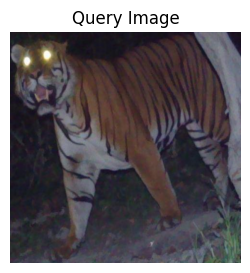

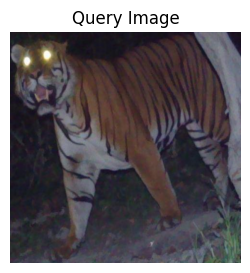

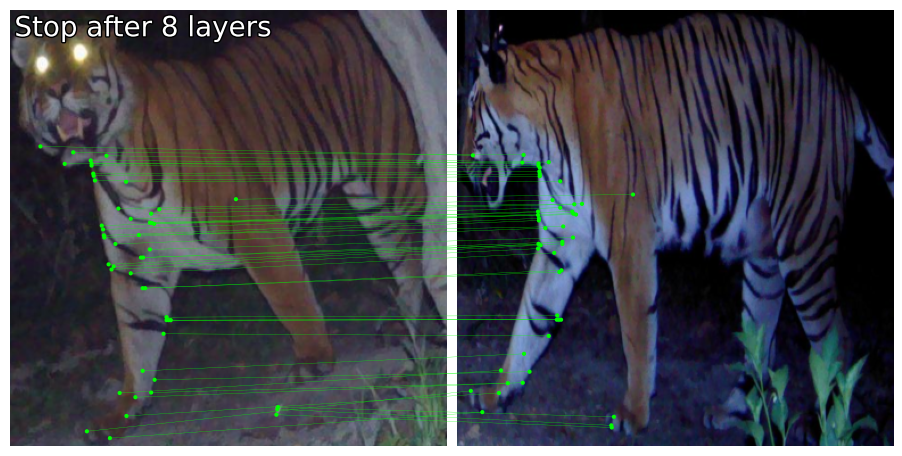

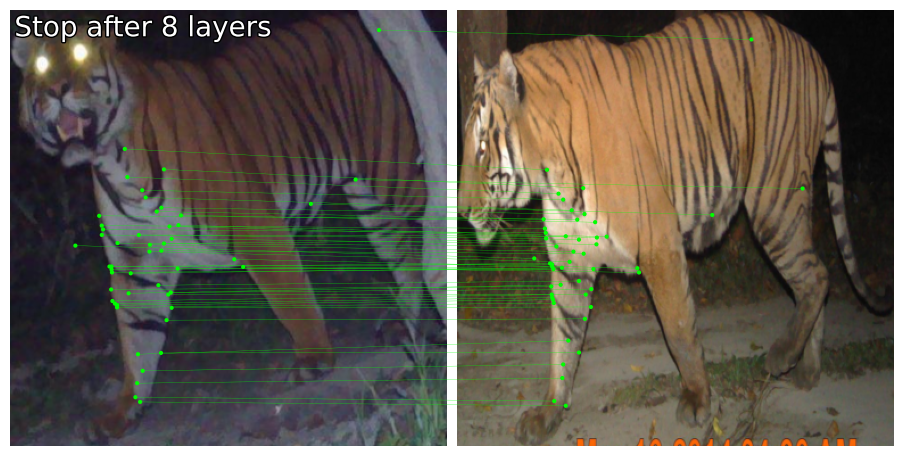

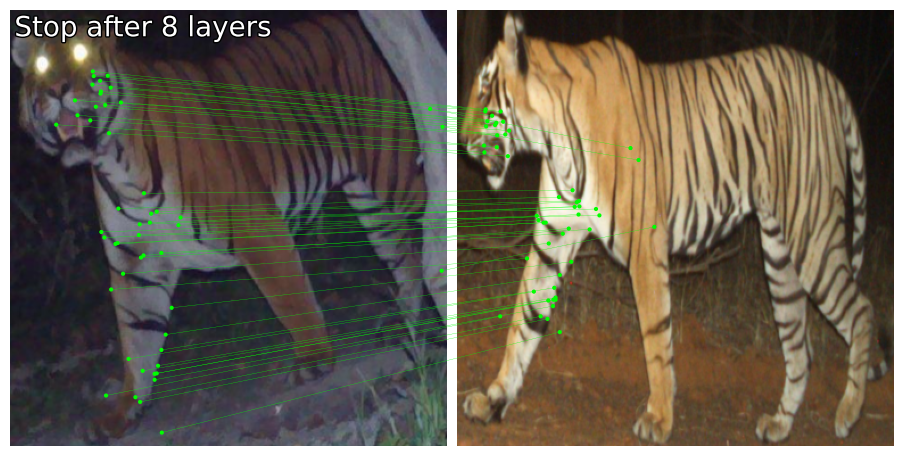

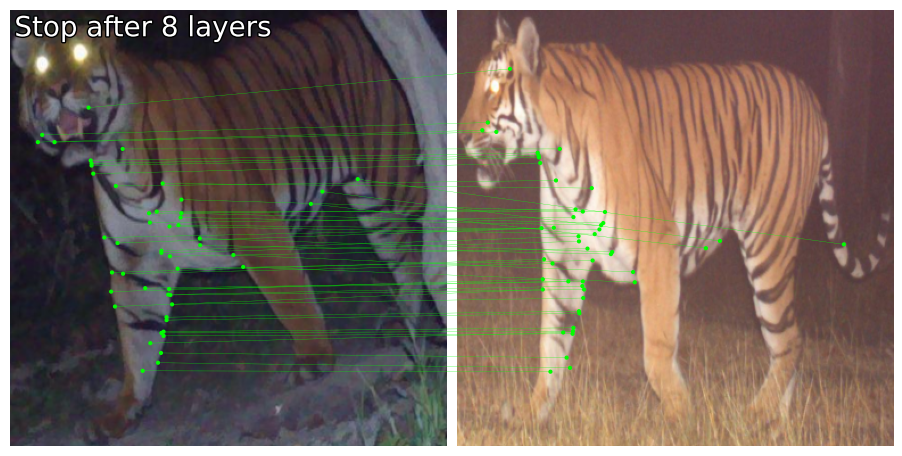

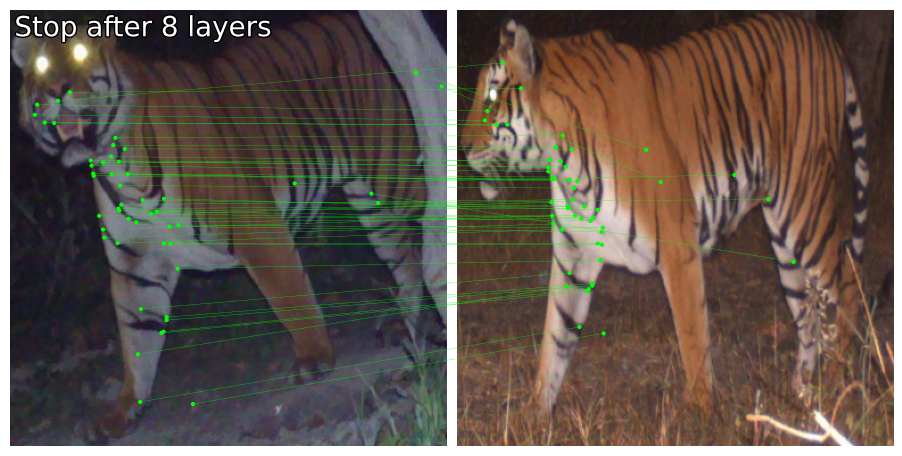

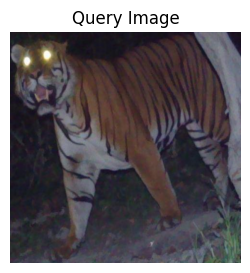

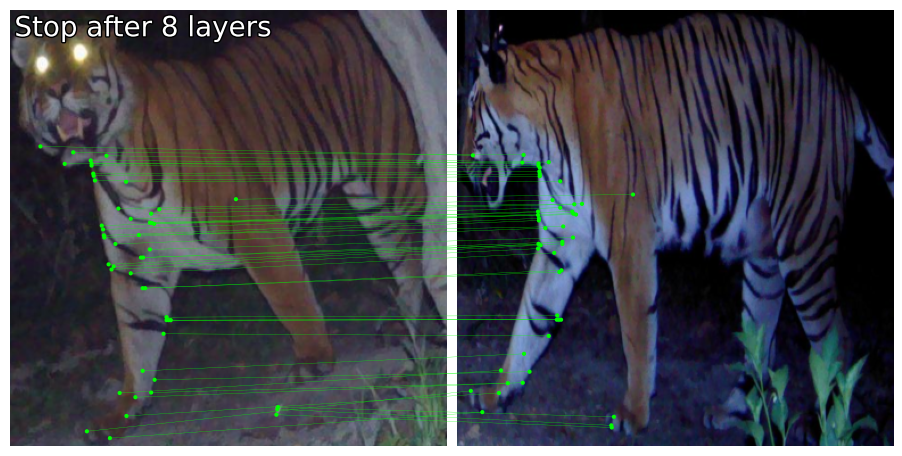

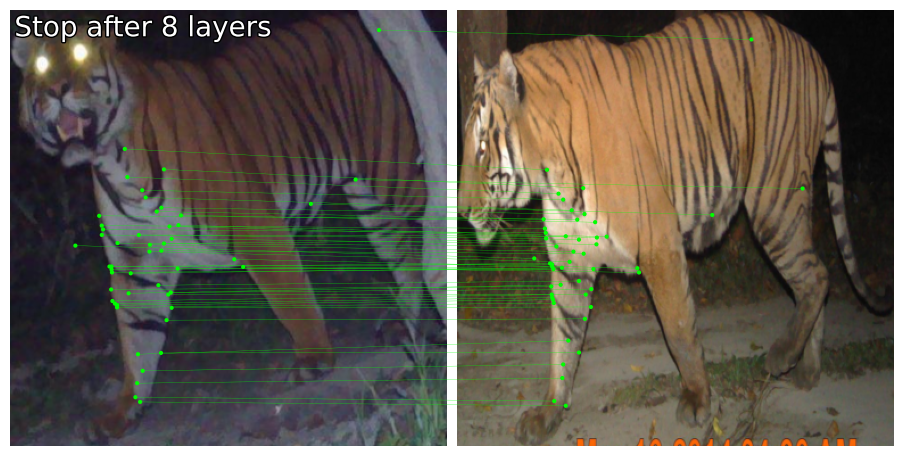

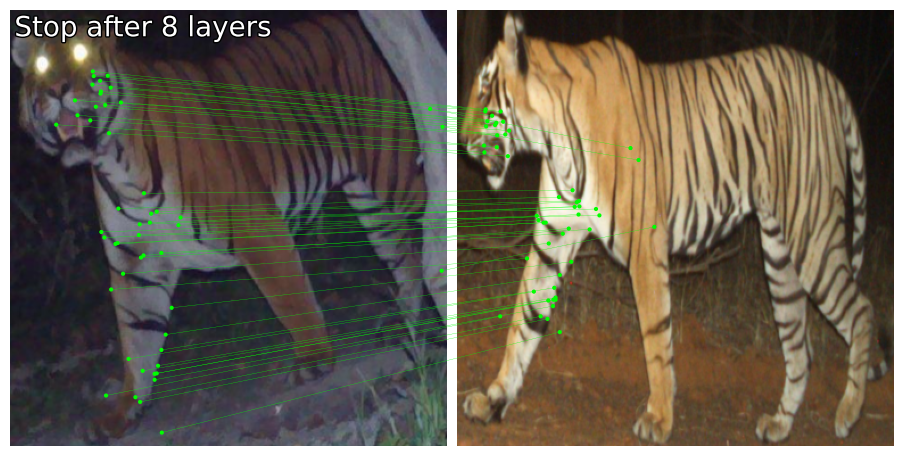

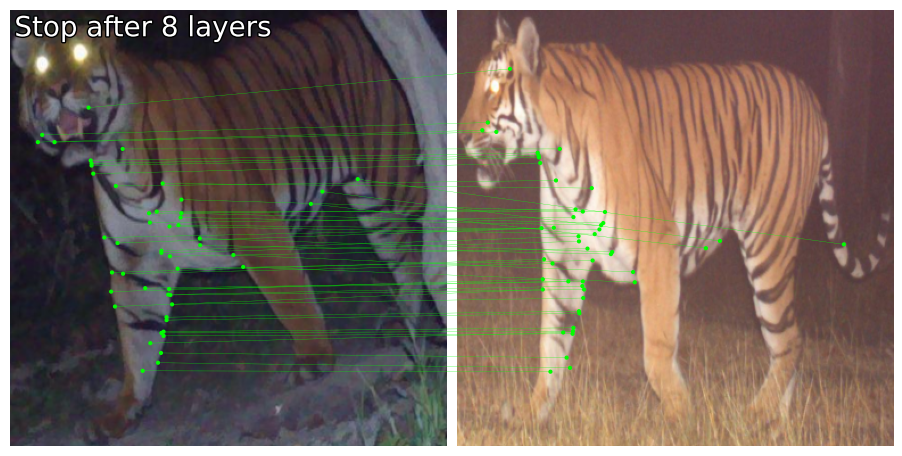

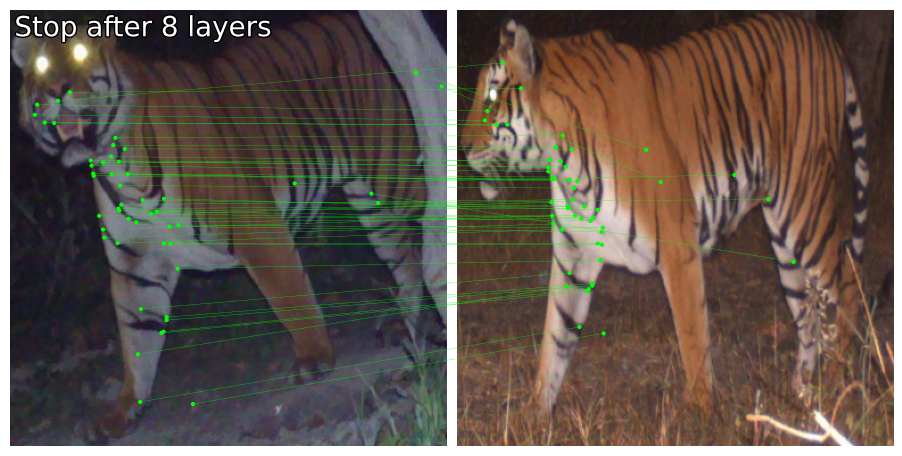

In [53]:
# display_img(dataset_query[8][0])
# display_img(dataset_gallery[1][0])
display_top_preds_matches(0)

In [68]:
# Get all feature embeddings of every image in the dataset. Make a t-SNE plot of the embeddings color-coded by identity.

# for each image in the dataset, compute the arcface feature embedding and store in a tensor
all_features = []
all_labels = []
for i in tqdm(range(len(dataset_gallery))):
    img, label = dataset_gallery[i]
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        feature = arcface(img)
    all_features.append(feature)
    all_labels.append(label)

for i in tqdm(range(len(dataset_query))):
    img, label = dataset_query[i]
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        feature = arcface(img)
    all_features.append(feature)
    all_labels.append(label)

all_features = torch.cat(all_features, dim=0)
all_labels = np.array(all_labels)


100%|██████████| 115/115 [00:04<00:00, 24.63it/s]


In [69]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_features = tsne.fit_transform(all_features.cpu().numpy())


/opt/conda/envs/py10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


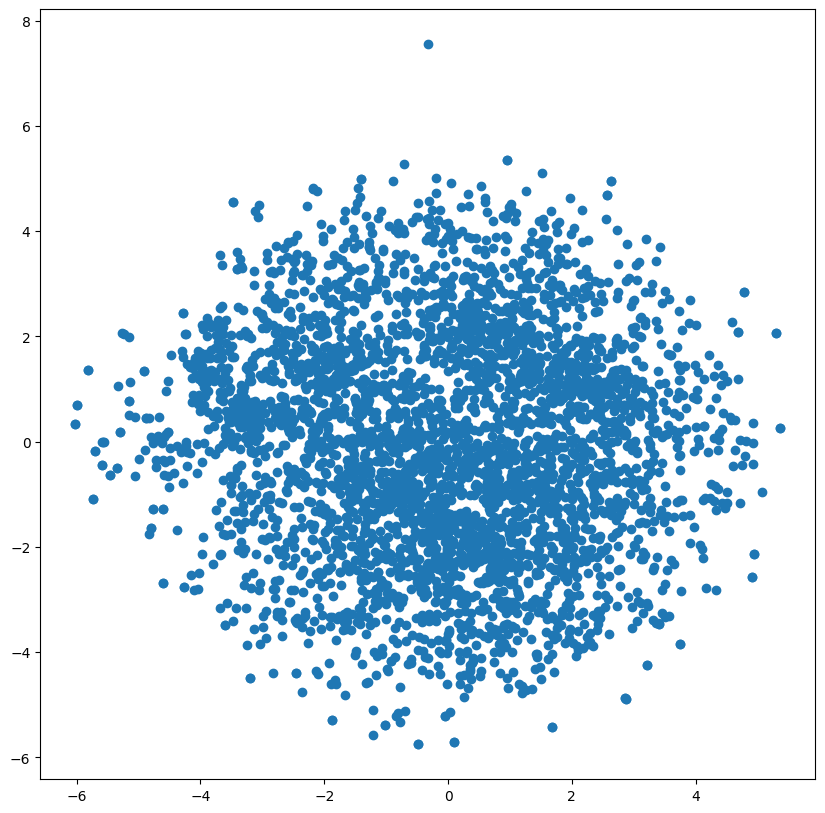

In [72]:
# # Create a color map based on the unique labels
# unique_labels = np.unique(all_labels)
# colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
# label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}

# # Plot t-SNE embeddings
# plt.figure(figsize=(10, 10))
# for label in unique_labels:
#     indices = all_labels == label
#     plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], color=label_to_color[label], label=label, s=10)

# plt.legend(title="Identity")
# plt.title("t-SNE plot of feature embeddings color-coded by identity")
# plt.xlabel("t-SNE feature 1")
# plt.ylabel("t-SNE feature 2")
# plt.show()

plt.figure(figsize=(10, 10))
for i in range(len(all_labels)):
    plt.scatter(tsne_features[i, 0], tsne_features[i, 1], c=all_labels[i], cmap="tab20")
    